In [1]:
import velvetvae as vt

# general packages
import numpy as np
import pandas as pd
import torch
from scipy.sparse import issparse

# velocity packages
import scanpy as sc
import scvelo as scv
import anndata as ann

# plotting packages
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm, trange
from IPython.display import clear_output

# color palette object
from colors import colorpalette as colpal

Global seed set to 0
/camp/home/maizelr/.local/lib/python3.10/site-packages/pytorch_lightning/utilities/warnings.py:53: LightningDeprecationWarning: pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6 and will be removed in v1.8. Use the equivalent function from the pytorch_lightning.utilities.rank_zero module instead.
  new_rank_zero_deprecation(
/camp/home/maizelr/.local/lib/python3.10/site-packages/pytorch_lightning/utilities/warnings.py:58: LightningDeprecationWarning: The `pytorch_lightning.loggers.base.rank_zero_experiment` is deprecated in v1.7 and will be removed in v1.9. Please use `pytorch_lightning.loggers.logger.rank_zero_experiment` instead.
  return new_rank_zero_deprecation(*args, **kwargs)


In [2]:
import os

In [3]:
def process_for_benchmarking(adata, layer, n_neighbors=50):
    X = adata.layers[layer]
    X = X.A if issparse(X) else X
    
    Xlog = np.log1p(X)
    pca = PCA()
    Xpca = pca.fit_transform(Xlog)
    adata.obsm['X_pca'] = Xpca
    try:
        adata.varm['precomputed_PCs'] = pca.components_
    except ValueError:
        pass
    
    if n_neighbors > 0:
        cnx = vt.pp.connectivities(total=X, n_neighbors=n_neighbors)
        Xsmooth = vt.pp.moments(X=X, cnx=cnx, n_neighbors=n_neighbors)
        Xlogsmooth = np.log1p(Xsmooth)
        pca = PCA()
        Xpcasmooth = pca.fit_transform(Xlogsmooth)
        adata.obsm['X_pca_smooth'] = Xpcasmooth
    else:
        adata.obsm['X_pca_smooth'] = Xpca
    return adata

# 1

In [4]:
adata = scv.datasets.pancreas()
os.system('rm -r ./data')

  0%|          | 0.00/50.0M [00:00<?, ?B/s]

0

In [5]:
sc.pp.filter_genes(adata, min_counts=10)

genes = vt.pp.select_genes(
    adata,
    n_variable_genes=3000,
)

s = adata[:,genes].layers['spliced'].copy()
u = adata[:,genes].layers['unspliced'].copy()

adata = vt.pp.size_normalize_splicing(
    adata, 
    genes=genes, 
    spliced_layer='spliced', 
    unspliced_layer='unspliced',
    unsparsify=True
)

adata.uns['raw_spliced_counts'] = s
adata.uns['raw_unspliced_counts'] = u

adata = process_for_benchmarking(adata, 'total')

adata.write_h5ad(f'../data/splicing_data/pancreas.h5ad')

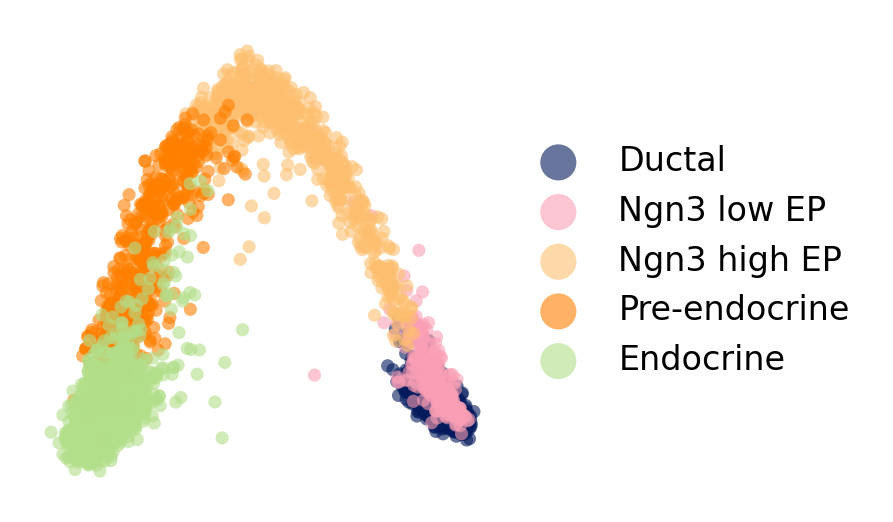

In [7]:
fig = plt.figure(figsize=(2,2), dpi=300)
ax = fig.subplots()

sc.pl.scatter(
    adata,
    basis="pca",
    color=['clusters_coarse'],
    frameon=False, ax=ax,
    size=40, alpha=.6,
    legend_loc='right margin',
    legend_fontsize=8, 
    legend_fontoutline=10,
    show=True, 
    title='',
    components='1,2'
)

# 2

In [8]:
adata = scv.datasets.dentategyrus()
os.system('rm -r ./data')
adata = adata[[a in ['Neuroblast', 'Granule immature', 'Granule mature'] for a in adata.obs['clusters']]]

  0%|          | 0.00/23.7M [00:00<?, ?B/s]

In [9]:
adata

View of AnnData object with n_obs × n_vars = 2272 × 13913
    obs: 'clusters', 'age(days)', 'clusters_enlarged'
    uns: 'clusters_colors'
    obsm: 'X_umap'
    layers: 'ambiguous', 'spliced', 'unspliced'

In [10]:
adata = adata.copy()

sc.pp.filter_genes(adata, min_counts=10)

genes = vt.pp.select_genes(
    adata,
    n_variable_genes=3000,
)

s = adata[:,genes].layers['spliced'].copy()
u = adata[:,genes].layers['unspliced'].copy()

adata = vt.pp.size_normalize_splicing(
    adata, 
    genes=genes, 
    spliced_layer='spliced', 
    unspliced_layer='unspliced',
    unsparsify=True
)

adata.uns['raw_spliced_counts'] = s
adata.uns['raw_unspliced_counts'] = u

adata = adata.copy()

adata = process_for_benchmarking(adata.copy(), 'total')

adata.write_h5ad(f'../data/splicing_data/dentategyrus.h5ad')

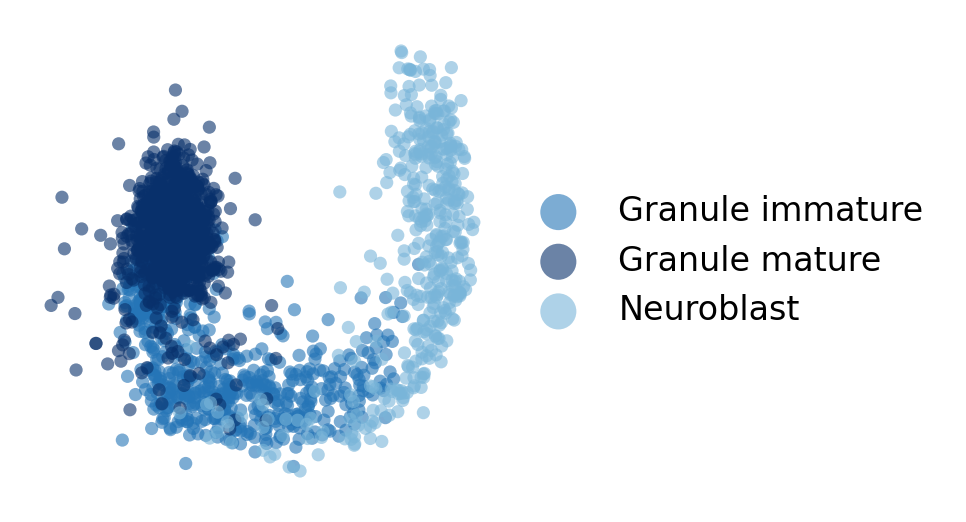

In [11]:
fig = plt.figure(figsize=(2,2), dpi=300)
ax = fig.subplots()

sc.pl.scatter(
    adata,
    basis="pca",
    color=['clusters'],
    frameon=False, ax=ax,
    size=40, alpha=.6,
    legend_loc='right margin',
    legend_fontsize=8, 
    legend_fontoutline=10,
    show=True, 
    title='',
    components='1,2'
)

# 3

In [12]:
adata = scv.datasets.forebrain()
os.system('rm -r ./data')
adata.obs['clusters'] = [str(a) for a in adata.obs.Clusters]

  0%|          | 0.00/29.2M [00:00<?, ?B/s]

In [13]:
adata = adata.copy()

sc.pp.filter_genes(adata, min_counts=10)

genes = vt.pp.select_genes(
    adata,
    n_variable_genes=3000,
)

s = adata[:,genes].layers['spliced'].copy()
u = adata[:,genes].layers['unspliced'].copy()

adata = vt.pp.size_normalize_splicing(
    adata, 
    genes=genes, 
    spliced_layer='spliced', 
    unspliced_layer='unspliced',
    unsparsify=True
)

adata.uns['raw_spliced_counts'] = s
adata.uns['raw_unspliced_counts'] = u

adata = process_for_benchmarking(adata, 'total')

adata.write_h5ad(f'../data/splicing_data/forebrain.h5ad')

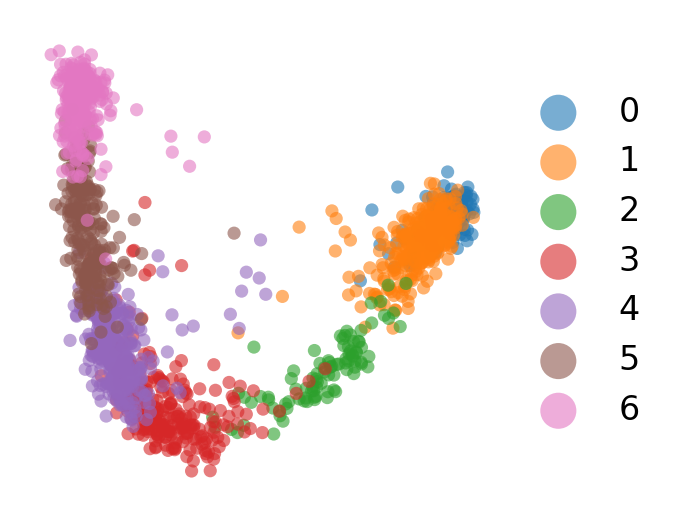

In [14]:
fig = plt.figure(figsize=(2,2), dpi=300)
ax = fig.subplots()

sc.pl.scatter(
    adata,
    basis="pca",
    color=['clusters'],
    frameon=False, ax=ax,
    size=40, alpha=.6,
    legend_loc='right margin',
    legend_fontsize=8, 
    legend_fontoutline=10,
    show=True, 
    title='',
    components='1,2'
)

# 4

In [15]:
adata = scv.datasets.dentategyrus_lamanno()
os.system('rm -r ./data')

adata = adata[[a in ['Nbl1','Nbl2','CA','CA2-3-4','ImmGranule1','ImmGranule2','Granule'] for a in adata.obs['clusters']]]



  0%|          | 0.00/249M [00:00<?, ?B/s]

In [16]:
adata = adata.copy()

sc.pp.filter_genes(adata, min_counts=10)

genes = vt.pp.select_genes(
    adata,
    n_variable_genes=3000,
)

s = adata[:,genes].layers['spliced'].copy()
u = adata[:,genes].layers['unspliced'].copy()

adata = vt.pp.size_normalize_splicing(
    adata, 
    genes=genes, 
    spliced_layer='spliced', 
    unspliced_layer='unspliced',
    unsparsify=True
)

adata.uns['raw_spliced_counts'] = s
adata.uns['raw_unspliced_counts'] = u

adata = process_for_benchmarking(adata, 'total')

adata.write_h5ad(f'../data/splicing_data/dentategyrus_lamanno.h5ad')

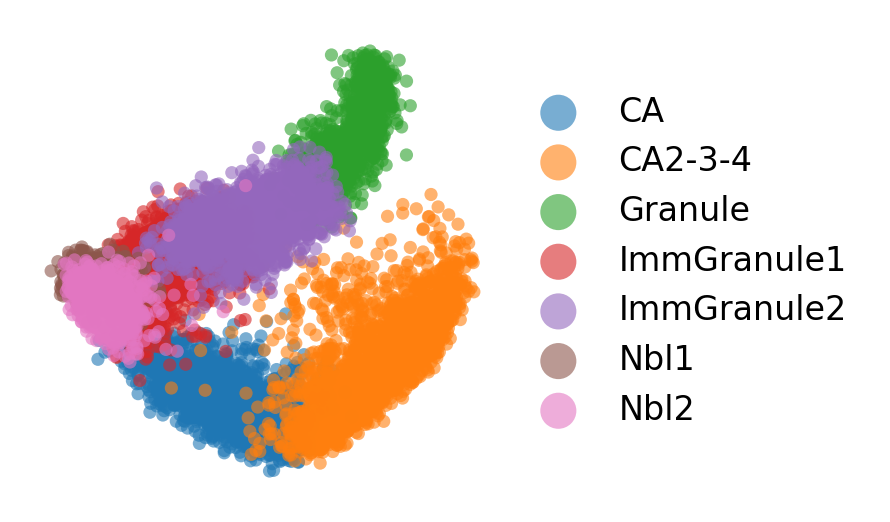

In [17]:
fig = plt.figure(figsize=(2,2), dpi=300)
ax = fig.subplots()

sc.pl.scatter(
    adata,
    basis="pca",
    color=['clusters'],
    frameon=False, ax=ax,
    size=40, alpha=.6,
    legend_loc='right margin',
    legend_fontsize=8, 
    legend_fontoutline=10,
    show=True, 
    title='',
    components='1,2'
)

# 5

In [18]:
murk_genes = """Hba-x
Smim1
Dcxr
Cox6b2
Gypa
Cpox
Hbb-bh1
Nudt4
Hbb-bt
Alad
Gpx1
Hba-a2
Slc25a21
Klf3
Hsd3b6
Tfrc
Mgst3
Tmem14c
Ftl1
Arf5
Ell2
Hbb-y
Fech
Ssbp2
Grap2
Rhag
Fam210b
Arid3a
Rfesd
Bpgm
Alas2
Abcg2
Hesx1
Hemgn
Pim1
Dhrs11
Chchd10
Txlng
Rmnd5b
Prdx2
Klhl26
Slc4a1
Blvrb
Abcb10
Hebp1
Ucp2
Mllt3
Pklr
Gclm
Aqp8
Lpcat1
Top1mt
Cdkn3
Gstm5
Cdc25b
Creg1
Dnaja4
Kcnn4
Slc30a10
Svbp
Tmod1
Klf1
Cdc42ep3
Celf4
Prr13
Arrb1
Cldn13
Glrx5
Ncf4
Ppox
Rragd
Ctsb
Ddias
Aqp3
Acp1
Ddc
Gadd45a
Nxpe2
Fam126a
Efcab2
Ypel3
Hbq1b
Mindy2
Icam4
Fuca2
Kdm7a
Htatip2
Asns
Slc25a37""".split("\n")

In [19]:
adata = scv.datasets.gastrulation_erythroid()
os.system('rm -r ./data')

  0%|          | 0.00/463M [00:00<?, ?B/s]

0

In [20]:
adata = adata.copy()

sc.pp.filter_genes(adata, min_counts=10)

genes = vt.pp.select_genes(
    adata,
    n_variable_genes=3000,
    unwanted_list=murk_genes
)

s = adata[:,genes].layers['spliced'].copy()
u = adata[:,genes].layers['unspliced'].copy()

adata = vt.pp.size_normalize_splicing(
    adata, 
    genes=genes, 
    spliced_layer='spliced', 
    unspliced_layer='unspliced',
    unsparsify=True
)

adata.uns['raw_spliced_counts'] = s
adata.uns['raw_unspliced_counts'] = u

adata = process_for_benchmarking(adata, 'total')

adata.write_h5ad(f'../data/splicing_data/gastrulation_erythroid.h5ad')

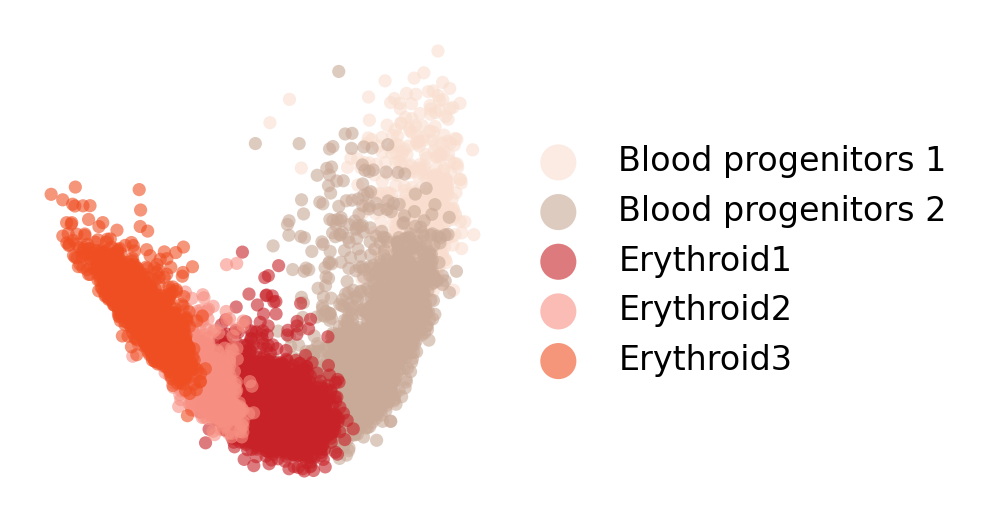

In [21]:
fig = plt.figure(figsize=(2,2), dpi=300)
ax = fig.subplots()

sc.pl.scatter(
    adata,
    basis="pca",
    color=['celltype'],
    frameon=False, ax=ax,
    size=40, alpha=.6,
    legend_loc='right margin',
    legend_fontsize=8, 
    legend_fontoutline=10,
    show=True, 
    title='',
    components='1,2'
)

# 6

In [22]:
delile_path = '/camp/lab/briscoej/home/users/maizelr/transcriptomics/mouse_transcriptomics_data/full_data/new_mouse_velocity_20210121.loom'
mousent = scv.read_loom(delile_path)
mousent.var = mousent.var.set_index('var_names')


In [23]:
adata = mousent[mousent.obs.domain=='MN']
adata

View of AnnData object with n_obs × n_vars = 1192 × 31053
    obs: 'Clusters', '_X', '_Y', 'cell_subtype', 'cell_type', 'domain', 'obs_names', 'orig_dataset', 'timepoint'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand'
    layers: 'matrix', 'ambiguous', 'spliced', 'unspliced'

In [24]:
adata = adata.copy()

sc.pp.filter_genes(adata, min_counts=10)

genes = vt.pp.select_genes(
    adata,
    n_variable_genes=3000,
)

s = adata[:,genes].layers['spliced'].copy()
u = adata[:,genes].layers['unspliced'].copy()

adata = vt.pp.size_normalize_splicing(
    adata, 
    genes=genes, 
    spliced_layer='spliced', 
    unspliced_layer='unspliced',
    unsparsify=True
)

adata.uns['raw_spliced_counts'] = s
adata.uns['raw_unspliced_counts'] = u

adata = process_for_benchmarking(adata, 'total')

sc.pp.neighbors(adata)
sc.tl.leiden(adata, resolution=.25)

adata.write_h5ad(f'../data/splicing_data/mouse_motor_neuron.h5ad')

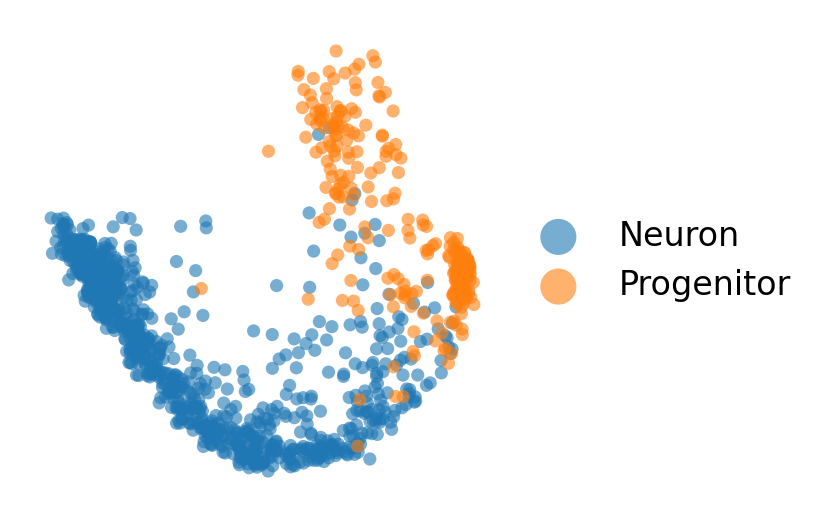

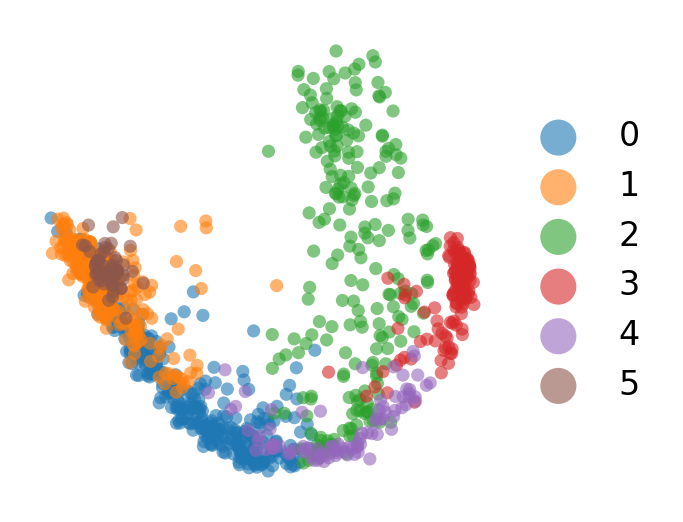

In [25]:
fig = plt.figure(figsize=(2,2), dpi=300)
ax = fig.subplots()

sc.pl.scatter(
    adata,
    basis="pca",
    color=['cell_type'],
    frameon=False, ax=ax,
    size=40, alpha=.6,
    legend_loc='right margin',
    legend_fontsize=8, 
    legend_fontoutline=10,
    show=True, 
    title='',
    components='1,2'
)

fig = plt.figure(figsize=(2,2), dpi=300)
ax = fig.subplots()

sc.pl.scatter(
    adata,
    basis="pca",
    color=['leiden'],
    frameon=False, ax=ax,
    size=40, alpha=.6,
    legend_loc='right margin',
    legend_fontsize=8, 
    legend_fontoutline=10,
    show=True, 
    title='',
    components='1,2'
)

In [26]:
dataset = [
    'pancreas',
    'dentategyrus',
    'forebrain',
    'dentategyrus_lamanno',
    'gastrulation_erythroid',
    'mouse_motor_neuron'
]

for name in dataset:
    old = f"../data/splicing_data/{name}.h5ad"
    new = f"../data/benchmarking/{name}.h5ad"
    os.system(f"cp {old} {new}")

In [27]:
print("Done!")

Done!
